### Import Libraries

In [1]:
# Filename imports
import glob

# Math and Image processing imports
import cv2
import numpy as np
import time

# Visualization imports
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

# Sci-Kit imports
from sklearn.svm import LinearSVC
from skimage.feature import hog
from scipy.ndimage.measurements import label
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### Import filepaths

In [2]:
## Import filenames
cars = glob.glob('vehicles/**/*.png')
notcars = glob.glob('non-vehicles/**/*.png')

print("Number of vehicle images:" + str(len(cars)))
print("Number of non-vehicle images:" + str(len(notcars)))

Number of vehicle images:8792
Number of non-vehicle images:8968


### View images

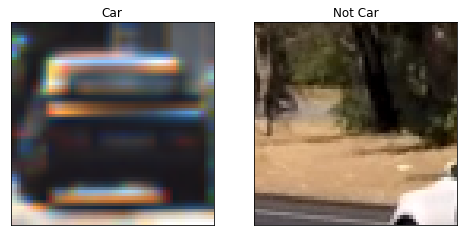

In [3]:
## Method to visualize images
def view_images(images, row, col, figsize, titles, type="image"):
    plt.figure(figsize=figsize)
    for idx, image in enumerate(images):
        plt.subplot(row,col,idx+1)
        plt.title(idx+1)
        if type=="image":
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
        elif type=="plot":
            plt.plot(image)
        plt.title(titles[idx])
    plt.savefig("./output_images/" + titles[1] +".png", transparent = False, bbox_inches='tight', pad_inches=0)

# Verify if we are getting good readings
car_idx = np.random.randint(0, len(cars))
notcar_idx = np.random.randint(0, len(notcars))
images = [mpimg.imread( cars[car_idx] ), mpimg.imread( notcars[notcar_idx] )]
titles = ["Car", "Not Car"]
view_images(images, 1, 2, (8,5), titles)

### Features Extraction

In [4]:
## Method to extract HOG features from images
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(
            cell_per_block, cell_per_block), transform_sqrt=False, visualise=vis, feature_vector=feature_vec)
        return features, hog_image

    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=False, visualise=vis, feature_vector=feature_vec)
        return features


## Method to calculate spatial bins
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:, :, 0], size).ravel()
    color2 = cv2.resize(img[:, :, 1], size).ravel()
    color3 = cv2.resize(img[:, :, 2], size).ravel()
#     features = cv2.resize(img, size).ravel() 
    features = np.hstack((color1, color2, color3))
    return features

## Method to calculate color histogram features
def color_hist(img, nbins=32):
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins)

    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features


## Method to extract feature for a single image 
def single_img_features(img, color_space='RGB', spatial_size=(32, 32), hist_bins=32, orient=9, pix_per_cell=8, 
                        cell_per_block=2, hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):
    # 1) Define an empty list to receive features
    img_features = []

    # 2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(img)
        
    # 3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, spatial_size)
        
        # 4) Append features to list
        img_features.append(spatial_features)
        
    # 5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        
        # 6) Append features to list
        img_features.append(hist_features)
        
    # 7) Compute HOG features if flag is set
    if hog_feat == True:

        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:, :, channel], orient, pix_per_cell, 
                                                     cell_per_block, vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            if vis==True:
                hog_features, hog_image = get_hog_features(feature_image[:, :, hog_channel], orient, pix_per_cell,
                                                           cell_per_block, vis=True, feature_vec=True)                    
            else:
                hog_features = get_hog_features(feature_image[:, :, hog_channel], orient, 
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # 8) Append features to list
        img_features.append(hog_features)
        
    # 9) Concatenate array of features
    concat_img_features = np.concatenate(img_features).astype(np.float64)
        
    # Return concatenated array
    if vis==True:
        return concat_img_features, hog_image
    else:
        return concat_img_features

## Extract feature for list of images
def extract_features(files, color_space='RGB', spatial_size=(32, 32), hist_bins=32, orient=9, pix_per_cell=8, 
                     cell_per_block=2, hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True):
    
    # 1) Define an empty list to receive features
    features = []
    # Iterate through all images
    for file in files:
        img_features = []
        # 2) Apply color conversion if other than 'RGB'
        image = mpimg.imread(file)
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)
        # 3) Compute spatial features if flag is set
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, spatial_size)
            # 4) Append features to list
            img_features.append(spatial_features)
        # 5) Compute histogram features if flag is set
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            # 6) Append features to list
            img_features.append(hist_features)
        # 7) Compute HOG features if flag is set
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:, :, hog_channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # 8) Append features to list
            img_features.append(hog_features)
        # 9) Return concatenated array of features
        features.append(np.concatenate(img_features))
    return features

## Method to convert color space
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

### Visualizatoin of Extracted Features

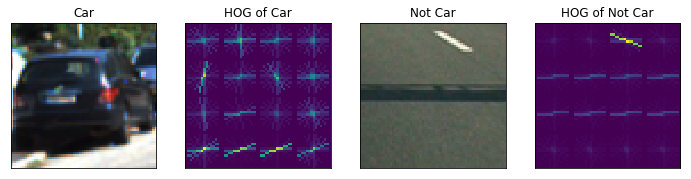

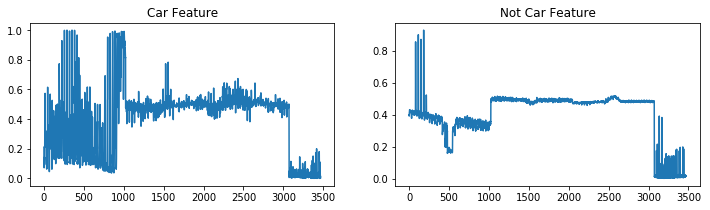

In [5]:
# Generate random index
car_idx = np.random.randint(0, len(cars))
notcar_idx = np.random.randint(0, len(notcars))

car_file = cars[car_idx]
notcar_file = notcars[notcar_idx]

car_image = mpimg.imread(cars[car_idx])
notcar_image = mpimg.imread(notcars[notcar_idx])

color_space = 'YCrCb'    # Options: RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size=(32,32)     # Spatial binning dimensions
hist_bins=32             # Number of histogram bins
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 0          # Options: 0,1,2 or 'ALL'
spatial_feat = True
hist_feat = False        
hog_feat = True

# Extract car image features
car_features, car_hog_image   = single_img_features(car_image, color_space=color_space,
                                                 spatial_size=spatial_size, hist_bins=hist_bins,
                                                 orient=orient,pix_per_cell=pix_per_cell,
                                                 cell_per_block=cell_per_block,hog_channel=hog_channel,
                                                 spatial_feat=spatial_feat,hist_feat=hist_feat,
                                                 hog_feat=hog_feat,vis=True)
# Extract notcar image features
notcar_features, notcar_hog_image = single_img_features(notcar_image, color_space=color_space,
                                                 spatial_size=spatial_size, hist_bins=hist_bins,
                                                 orient=orient,pix_per_cell=pix_per_cell,
                                                 cell_per_block=cell_per_block,hog_channel=hog_channel,
                                                 spatial_feat=spatial_feat,hist_feat=hist_feat,
                                                 hog_feat=hog_feat,vis=True)

images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
titles = ["Car", "HOG of Car", "Not Car", "HOG of Not Car"]
view_images(images, 1, 4, (12,3), titles)

features = [car_features, notcar_features]
titles = ["Car Feature", "Not Car Feature"]
view_images(features, 1, 2, (12,3), titles, type="plot")

### Training SVM and Tuning Hyperparameters

In [6]:
car_file = cars[car_idx]
notcar_file = notcars[notcar_idx]

color_space = 'YCrCb'     # Options: RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size=(32,32)      # Spatial binning dimensions
hist_bins=32              # Number of histogram bins
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'       # Options: 0,1,2 or 'ALL'
spatial_feat = True
hist_feat = True
hog_feat = True

t = time.time()
n_samples = 1000
random_idxs = np.random.randint(0, len(cars), n_samples)

test_cars = cars
test_notcars = notcars

# Extract Features for all car and non car images
car_features = extract_features(test_cars, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient,pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=spatial_feat,hist_feat=hist_feat, 
                                hog_feat=hog_feat)

notcar_features = extract_features(test_notcars, color_space=color_space, spatial_size=spatial_size, 
                                   hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                   cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat,
                                   hist_feat=hist_feat, hog_feat=hog_feat)

print(time.time() - t, 'Seconds to compute features...')
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Prepare a scaler to correct data scale
X_scaler = StandardScaler().fit(X)

# Apply the scaler
scaled_X = X_scaler.transform(X)

# Get label vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Initialize
rand_state=np.random.randint(0,100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.1, random_state=rand_state)

print("Using:", orient, " orientations,", pix_per_cell, " pixels per cell,", 
      cell_per_block, " cells per block,", hist_bins, " histogram bins and ", 
      spatial_size, " spatial sampling")

print('Feature vector length:', len(X_train[0]))

# Define the classifier
svc = LinearSVC()
t = time.time()

svc.fit(X_train, y_train)
print(round(time.time() - t, 2), " Seconds to train SVC")

print('Test accuracy of SVC: ', round(svc.score(X_test, y_test), 4))

120.80730104446411 Seconds to compute features...
Using: 9  orientations, 8  pixels per cell, 2  cells per block, 32  histogram bins and  (32, 32)  spatial sampling
Feature vector length: 8460
11.64  Seconds to train SVC
Test accuracy of SVC:  0.9927


### Make Predictions

In [7]:
## Slide thorugh the image and get the list of windows
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan / nx_pix_per_step) - 1
    ny_windows = np.int(yspan / ny_pix_per_step) - 1
    
    # Initialize a list to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs * nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys * ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]

            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    
    # Return the list of windows
    return window_list


## Search windows and predict whether its a car or not
def search_windows(img, windows, clf, scaler, color_space='RGB',
                  spatial_size=(32,32), hist_bins=32,
                  hist_range=(0,256), orient=9,
                  pix_per_cell=8, cell_per_block=2,
                  hog_channel=0, spatial_feat=True,
                  hist_feat=True, hog_feat=True):
    
    # create empty list to collect positive prediction
    on_windows=[]
    
    # Iterate through all windows
    for window in windows:
        # Extract window from image
        test_img = cv2.resize(img[ window[0][1]:window[1][1], window[0][0]:window[1][0] ], (64,64))
        
        # Extract feature vector for that single images
        features = single_img_features(test_img, color_space=color_space, spatial_size=spatial_size, 
                                       hist_bins=hist_bins, orient=orient, pix_per_cell = pix_per_cell,
                                       cell_per_block=cell_per_block, hog_channel=hog_channel, 
                                       spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
        
        # Scale the feature vector according to the clf
        test_features=scaler.transform(np.array(features).reshape(1, -1))
        
        # Make prediction
        prediction = clf.predict(test_features)
        
        # Append if positive prediction
        if prediction == 1:
            on_windows.append(window)
    return on_windows


## Draw rectangle
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

1.1013619899749756 	 seconds to process one image search 185  windows
0.9991228580474854 	 seconds to process one image search 185  windows
1.0006020069122314 	 seconds to process one image search 185  windows
0.9987549781799316 	 seconds to process one image search 185  windows
0.9871170520782471 	 seconds to process one image search 185  windows
1.0028879642486572 	 seconds to process one image search 185  windows


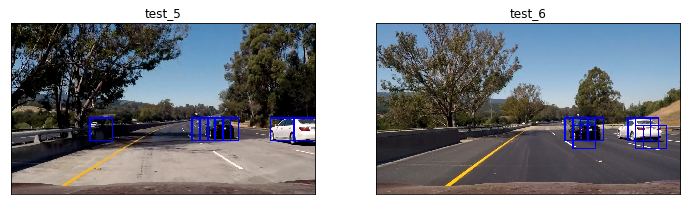

In [8]:
search_path = 'test_images/*.jpg'
example_images = glob.glob(search_path)

images = []
titles = []

y_start_stop = [400, 600]
overlap = 0.65

for img_src in example_images:
    t1 = time.time()

    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255 # Normalizing as trained image is png but test image is jpg.
    
    # Get the list of window by sliding throught the image
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop,
                          xy_window=(96,96), xy_overlap=(overlap, overlap))

    # Search in the window
    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel,spatial_feat=spatial_feat,
                                hist_feat=hist_feat, hog_feat=hog_feat)
    
    # Draw box around the hot windows
    window_img = draw_boxes(draw_img, hot_windows, color=(0, 0 , 255), thick=6)
    images.append(window_img)
    titles.append(img_src[:])
    
    print(time.time() - t1, '\t seconds to process one image search', len(windows), ' windows')

view_images(images[4:6], 1, 2, (12,18), ["test_5", "test_6"])

### Generate Heatmaps

0.3587617874145508 	 seconds to run , total windows:  196
0.3461489677429199 	 seconds to run , total windows:  196
0.3574948310852051 	 seconds to run , total windows:  196
0.34948086738586426 	 seconds to run , total windows:  196
0.34669017791748047 	 seconds to run , total windows:  196
0.34741806983947754 	 seconds to run , total windows:  196


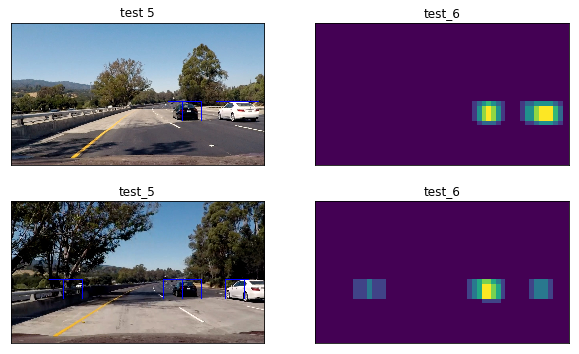

In [9]:
out_images = []
out_titles = []

ystart = 400
ystop  = 600
scale  = 1.5

for img_src in example_images:
    img_boxes = []
    t = time.time()
    count = 0
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    
    # Make a heatmap of zeros
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient * cell_per_block**2
    
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2 # instead of overlap define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Get HOG features
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
 
    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell
            
            # Extract image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            # Get Color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart), (0, 0, 255))
                img_boxes.append(((xbox_left,ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)) )
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
                
    print(time.time() - t, '\t seconds to run , total windows: ', count)
    
    out_images.append(draw_img)
    out_images.append(heatmap)
    out_titles.append(img_src[:])
    out_titles.append(img_src[:])

view_images(out_images[6:10], 2, 2, (10,6), ["test 5", "test_6", "test_5", "test_6"])

### Define the Car Detection Pipeline

In [10]:
# Wrap above routine to define find cars function available to rest of the code
def find_cars(img, scale):
    count = 0
    draw_img = np.copy(img)
    
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient * cell_per_block**2
    
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2 # instead of overlap define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell
            
            # Extract image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            # Get Color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart), (0, 0, 255))
                img_boxes.append(((xbox_left,ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)) )
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1

    return draw_img, heatmap

### Filter Heatmaps

In [11]:
from scipy.ndimage.measurements import label

## Filter heatmaps (reduce false positives)
def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

## Label the bounding box of the heatmap
def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1] + 1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
    return img

## Class to keep buffer of heatmaps and build confidence
class HeatmapsBuffer:
    """
    Buffer of heatmaps
    """
    def __init__(self, max_heatmaps):
        self.heatmaps = []
        self.max_heatmaps = max_heatmaps

    def size(self):
        return len(self.heatmaps)
    
    def enqueue(self, heatmap):
        self.heatmaps.insert(0, heatmap)

    def dequeue(self):
        num_element_before = len(self.heatmaps)
        self.heatmaps.pop()
        num_element_after = len(self.heatmaps)
        assert num_element_before == (num_element_after + 1)

    def sum_heatmaps(self):
        if self.size() > self.max_heatmaps:
            self.dequeue()
        all_heatmaps = np.array(self.heatmaps)
        return np.sum(all_heatmaps, axis=0)

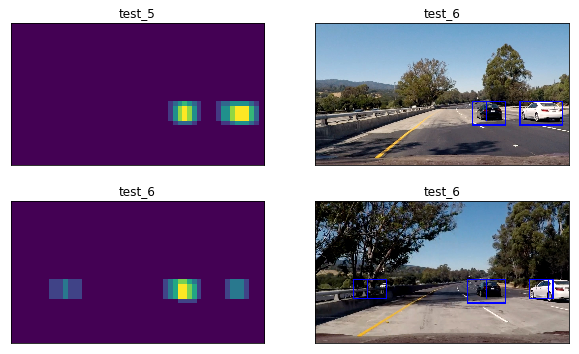

In [12]:
## Vehicle detection pipeline tuning
out_images = []
out_titles = []

ystart = 400
ystop = 600
scale = 1.5

for img_src in example_images:
    img = mpimg.imread(img_src)
    
    # find cars
    out_img, heat_map = find_cars(img, scale)
    labels = label(heat_map)

    draw_img = draw_labeled_bboxes(np.copy(out_img), labels)        

    out_images.append(heat_map)
    out_images.append(draw_img)    
    out_titles.append(img_src[:])
    out_titles.append(img_src[:])
    
view_images(out_images[6:10], 2, 2, (10,6), ["test_5", "test_6", "test_6", "test_6"])

### Define Complete Pipeline

In [13]:
## Vehicle Detection Pipeline (with false-positive filter)

# Filter parameters
map_buffer = HeatmapsBuffer(25)
heatmap_threshold = 15

def processing_pipeline(img):
    image, heat_map = find_cars(img, scale)
    map_buffer.enqueue(heat_map)
    all_heatmaps = map_buffer.sum_heatmaps()
    heat_map = apply_threshold(all_heatmaps, heatmap_threshold)
    labels = label(heat_map)
    
    output = draw_labeled_bboxes(np.copy(img), labels)
    return output

### Generate Video

In [14]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output_file= 'project_video_processed.mp4'
video_in   = VideoFileClip("project_video.mp4")
video_out  = video_in.fl_image(processing_pipeline)
%time video_out.write_videofile(output_file, audio=False)

[MoviePy] >>>> Building video project_video_processed.mp4
[MoviePy] Writing video project_video_processed.mp4


100%|█████████▉| 1260/1261 [08:30<00:00,  2.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_processed.mp4 

CPU times: user 7min 55s, sys: 38.2 s, total: 8min 33s
Wall time: 8min 31s
